In [8]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from datasets import DatasetDict
import numpy as np
from torchvision.transforms import Resize, Compose, Normalize, Lambda
import torchaudio.transforms as T
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import models
from torchaudio.transforms import TimeMasking, TimeStretch, FrequencyMasking
import torch.nn.functional as F
from torchmetrics import Accuracy, F1Score, ConfusionMatrix
from sklearn.utils.class_weight import compute_class_weight
import wandb
from ecallisto_dataset import randomly_reduce_class_samples, EcallistoDataset
from ecallisto_model import EfficientNet

# Modeling
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("GPU is not available.")
    device = 'cpu'

PyTorch version 2.2.1+cu121
GPU is available: NVIDIA GeForce RTX 4070 Laptop GPU


In [9]:
ds = load_dataset('i4ds/radio-sunburst-ecallisto')

In [10]:
ds_train = randomly_reduce_class_samples(ds['train'], 0, 0.2)

In [11]:
ds_train[0]['antenna']

'HUMAIN_59'

In [12]:
np.array(ds_train[0]['image']).shape

(193, 257)

In [13]:
ds_train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=257x193>,
 'label': 0,
 'antenna': 'HUMAIN_59',
 'datetime': '2022-10-19 14:49:00'}

In [22]:
import torch
from collections import defaultdict
import yaml
from tqdm import tqdm

# Initialize dictionary to hold the statistics for each antenna
antenna_stats = defaultdict(lambda: {'mean': 0, 'M2': 0, 'n_elements': 0, 'min': float('inf'), 'max': float('-inf')})

for entry in tqdm(ds['train'], desc="Processing dataset"):
    x = torch.tensor(pil_to_tensor(entry['image']), dtype=torch.float)
    antenna = entry['antenna']

    # Update count, mean, and M2
    n = x.numel()
    new_mean = torch.mean(x).item()
    new_variance = torch.var(x, unbiased=False).item()  # Use unbiased=False for a population variance
    new_count = n

    # Retrieve current stats for the antenna
    cur_stats = antenna_stats[antenna]
    delta = new_mean - cur_stats['mean']
    cur_stats['mean'] += delta * new_count / (cur_stats['n_elements'] + new_count)
    cur_stats['M2'] += new_variance * new_count + delta ** 2 * cur_stats['n_elements'] * new_count / (cur_stats['n_elements'] + new_count)
    cur_stats['n_elements'] += new_count

    # Update min and max
    cur_stats['min'] = min(cur_stats['min'], torch.min(x).item())
    cur_stats['max'] = max(cur_stats['max'], torch.max(x).item())

    # Update the dictionary
    antenna_stats[antenna] = cur_stats

# Finalize variance and std calculation and store results
final_stats = {}
for antenna, stats in antenna_stats.items():
    variance = stats['M2'] / stats['n_elements']  # This is the population variance
    std = torch.sqrt(torch.tensor(variance)).item()
    final_stats[antenna] = {'mean': stats['mean'], 'std': std, 'min': stats['min'], 'max': stats['max']}

# Save to YAML
with open('antenna_stats.yaml', 'w') as file:
    yaml.dump(final_stats, file, default_flow_style=False)

Processing dataset:   0%|          | 0/72121 [00:00<?, ?it/s]C:\Users\vince\AppData\Local\Temp\ipykernel_36236\405553127.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pil_to_tensor(entry['image']), dtype=torch.float)
Processing dataset: 100%|██████████| 72121/72121 [01:31<00:00, 791.01it/s] 


In [24]:
antenna_stats

defaultdict(<function __main__.<lambda>()>,
            {'ALASKA-COHOE_63': {'mean': 149.1321458233613,
              'M2': 78433850606.9847,
              'n_elements': 376215479,
              'min': 112.0,
              'max': 254.0},
             'AUSTRIA-UNIGRAZ_01': {'mean': 182.03233244396893,
              'M2': 32931507181.1648,
              'n_elements': 316800576,
              'min': 102.0,
              'max': 254.0},
             'Australia-ASSA_02': {'mean': 155.65044697122406,
              'M2': 13368786529.05955,
              'n_elements': 98776240,
              'min': 7.0,
              'max': 254.0},
             'Australia-ASSA_62': {'mean': 151.21854077833797,
              'M2': 77598195652.69315,
              'n_elements': 465092172,
              'min': 109.0,
              'max': 254.0},
             'GERMANY-DLR_63': {'mean': 144.26421983537324,
              'M2': 82462257294.99763,
              'n_elements': 245058855,
              'min': 110.0,
     

In [4]:
np.unique(ds['train']['label'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([60051,     3,   482,  9814,    78,   224,  1469], dtype=int64))

In [5]:
np.unique(ds_train['label'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([12010,     3,   482,  9814,    78,   224,  1469], dtype=int64))

In [6]:
dd = DatasetDict()
dd['train'] = ds_train
dd['test'] = ds['test']
dd['validation'] = ds['validation']

In [7]:
normalize = Normalize(mean=0.5721, std=0.1100)
size = (224, 244)

In [8]:
base_transform = Compose([
    Resize(size),  # Resize the image
])
data_augm_transform = Compose([
    T.FrequencyMasking(freq_mask_param=30),  # Apply frequency masking
    T.TimeMasking(time_mask_param=30),  # Apply time masking
])

normalize_transform = Compose([
    normalize,  # Normalize the image
])

In [9]:
ds_train = EcallistoDataset(dd['train'], binary_class=False, base_transform=base_transform, data_augm_transform=data_augm_transform, normalization_transform=normalize_transform)
ds_valid = EcallistoDataset(dd['validation'],  binary_class=False, base_transform=base_transform, normalization_transform=normalize_transform)
ds_test = EcallistoDataset(dd['test'],  binary_class=False,  base_transform=base_transform, normalization_transform=normalize_transform, return_all_columns=True)

In [10]:
# Compute class weights
class_weights = ds_train.get_sample_weights()
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)

In [11]:
BATCH_SIZE = 32

In [12]:
train_dataloader = DataLoader(ds_train,
                    batch_size=BATCH_SIZE,
                    num_workers=0,
                    shuffle=False,
                    sampler=sampler)

val_dataloader = DataLoader(ds_valid,
                    batch_size=BATCH_SIZE,
                    num_workers=0,
                    shuffle=False)

Label: 5, Augmentation Probability: 0.013392857142857142, Random Number: 0.5184394157540244
No augmentation applied
Label: 1, Augmentation Probability: 1.0, Random Number: 0.8741723264531233
Applying augmentation
Label: 5, Augmentation Probability: 0.013392857142857142, Random Number: 0.6945819230812454
No augmentation applied
Label: 4, Augmentation Probability: 0.03846153846153846, Random Number: 0.5853859337564729
No augmentation applied
Label: 6, Augmentation Probability: 0.0020422055820285907, Random Number: 0.9927657229588008
No augmentation applied
Label: 1, Augmentation Probability: 1.0, Random Number: 0.08330355986217286
Applying augmentation
Label: 4, Augmentation Probability: 0.03846153846153846, Random Number: 0.3782400026835442
No augmentation applied
Label: 3, Augmentation Probability: 0.00030568575504381494, Random Number: 0.9092076169896764
No augmentation applied
Label: 2, Augmentation Probability: 0.006224066390041493, Random Number: 0.26412518533182827
No augmentation

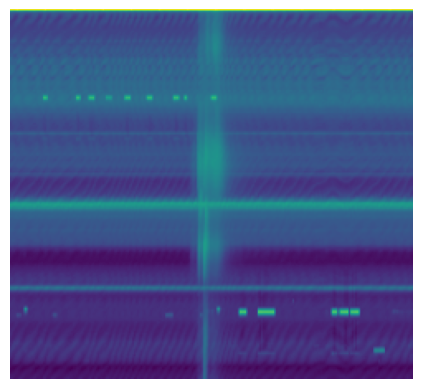

In [13]:
# Fetch a batch from the training dataloader
train_features, train_labels = next(iter(train_dataloader))


# Function to visualize an image
def show_image(img):
    # If the image tensor has 3 channels, rearrange the dimensions to (height, width, channels)
    img = img.squeeze()
    print(train_labels[0])
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis labels
    plt.show()

# Visualize the first image in the batch from the training set
show_image(train_features[0])


In [14]:
from collections import Counter

# Initialize a Counter object to keep track of class frequencies
class_counts = Counter()

# Iterate through the DataLoader
num_samples_seen = 0
for images, labels in train_dataloader:
    # Update counts
    class_counts.update(labels.numpy())
    
    # Update the number of samples seen
    num_samples_seen += len(labels)
    if num_samples_seen >= 10000:
        break

# Display the class distribution
print(class_counts)

Counter({2: 1482, 5: 1442, 0: 1441, 1: 1435, 6: 1435, 4: 1420, 3: 1361})


In [ ]:
wandb.init(entity='vincenzo-timmel')
wandb_logger = WandbLogger(log_model="all")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vincenzo-timmel. Use `wandb login --relogin` to force relogin


In [ ]:
# Checkpoint to save the best model based on the lowest validation loss
checkpoint_callback_loss = ModelCheckpoint(
    monitor='val_loss',
    dirpath=wandb_logger.experiment.dir,
    filename='efficientnet-loss-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

# Checkpoint to save the best model based on the highest F1 score
checkpoint_callback_f1 = ModelCheckpoint(
    monitor='val_f1',
    dirpath=wandb_logger.experiment.dir,
    filename='efficientnet-f1-{epoch:02d}-{val_f1:.2f}',
    save_top_k=1,
    mode='max',
)

c:\Users\vince\miniconda3\envs\flaresense-v2\Lib\site-packages\pytorch_lightning\loggers\wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [ ]:
model = EfficientNet(len(np.unique(dd['train']['label'])), torch.tensor(cw, dtype=torch.float))

In [ ]:
trainer = Trainer(
    accelerator='gpu', 
    max_epochs=1, 
    logger=wandb_logger,
    callbacks=[checkpoint_callback_loss, checkpoint_callback_f1],
    val_check_interval=200)
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\vince\miniconda3\envs\flaresense-v2\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\vince\FlareSense-v2\wandb\run-20240304_183127-eugldxv0\files exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | efficient_net | EfficientNet              | 20.2 M
1 | accuracy      | MulticlassAccuracy        | 0     
2 | f1_scor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\vince\miniconda3\envs\flaresense-v2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\vince\miniconda3\envs\flaresense-v2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\vince\miniconda3\envs\flaresense-v2\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
